In [8]:
using Printf, DelimitedFiles
using Plots
using DataFrames
using Revise, MDToolbox

In [9]:
#using BSON: @save, @load
#@load "df.bson" df

In [10]:
using JLD2

df = load("df.jld2")["df"];

In [11]:
d = load("df.jld2")

Dict{String, Any} with 1 entry:
  "df" => 100000×7 DataFrame…

In [12]:
sort!(df, [:score], rev=true);
#dfs = vcat(df, df)
#sort!(dfs, [:score], rev=true)

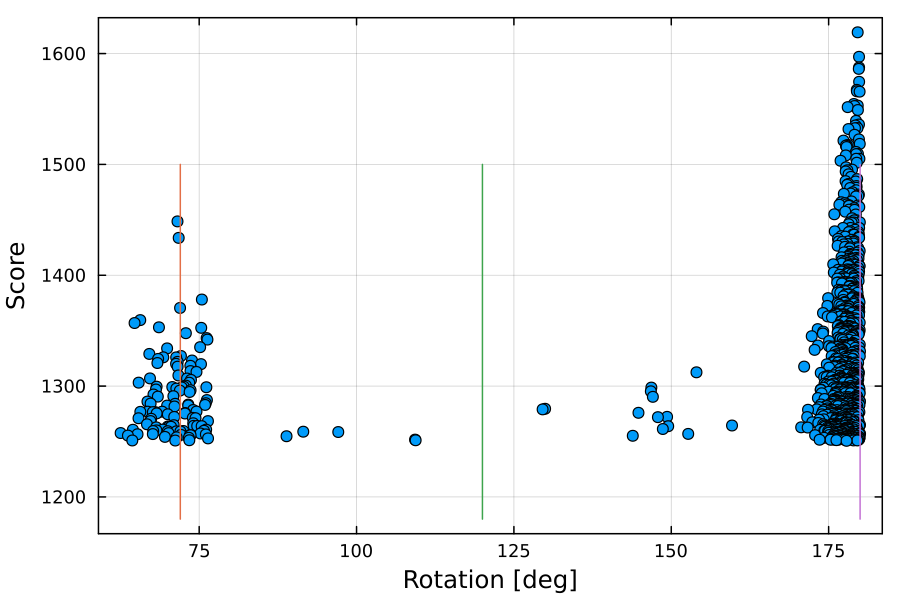

In [13]:
#pyplot()
plot(df.phi[1:1000], df.score[1:1000], seriestype=:scatter, dpi=250, label=nothing, box_style=:box)
xaxis!("Rotation [deg]"); yaxis!("Score")
#s = collect(970:1350)
s = collect(1180:1500)
plot!(fill(360/5, length(s)), s, label=nothing, dpi=250)
plot!(fill(360/3, length(s)), s, label=nothing, dpi=250)
plot!(fill(360/2, length(s)), s, label=nothing, dpi=150)

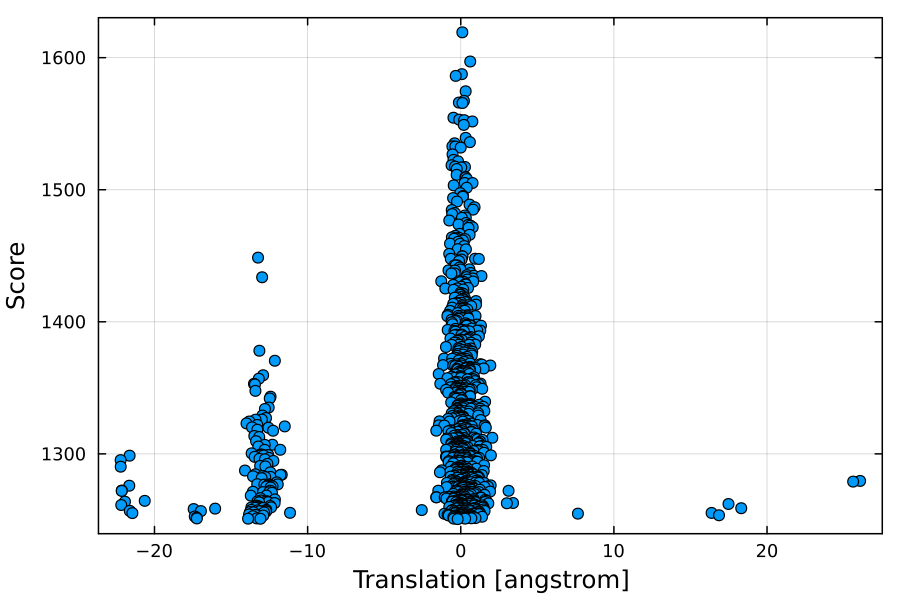

In [14]:
#pyplot()
plot(df.d[1:1000], df.score[1:1000], seriestype=:scatter, dpi=150, label=nothing, box_style=:box)
xaxis!("Translation [angstrom]"); yaxis!("Score")

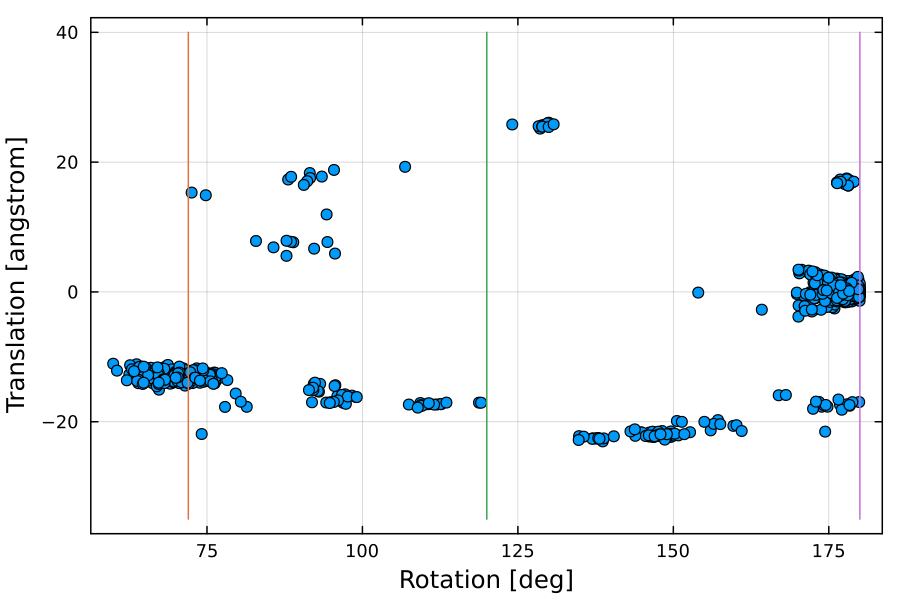

In [15]:
#pyplot()
plot(df.phi[1:2000], df.d[1:2000], seriestype=:scatter, dpi=150, label=nothing, box_style=:box)
xaxis!("Rotation [deg]"); yaxis!("Translation [angstrom]")
s = collect(-35:40)
plot!(fill(360/5, length(s)), s, label=nothing, dpi=250)
plot!(fill(360/3, length(s)), s, label=nothing, dpi=250)
plot!(fill(360/2, length(s)), s, label=nothing, dpi=150)

In [16]:
function create_heatmap(x, y, z, nx, ny)
    A = zeros(Float64, ny, nx)
    A .= -Inf64
    #edge_x = range(minimum(x), maximum(x), nx+1)
    edge_x = range(20, 190, nx+1)
    edge_y = range(minimum(y), maximum(y), ny+1)
    for ix in 1:nx
        for iy in 1:ny
            id_x = edge_x[ix] .<= x .< edge_x[ix+1]
            id_y = edge_y[iy] .<= y .< edge_y[iy+1]
            id = id_x .& id_y
            if !isempty(z[id])
                A[iy, ix] = maximum(z[id])
            end
        end
    end
    grid_x = edge_x[1:end-1] .+ (0.5 * (edge_x[2] - edge_x[1])) .+ (edge_x[2] - edge_x[1])
    grid_y = edge_y[1:end-1] .+ (0.5 * (edge_y[2] - edge_y[1])) .+ (edge_y[2] - edge_y[1])    
    return (z=A, x=grid_x, y=grid_y)
end

create_heatmap (generic function with 1 method)

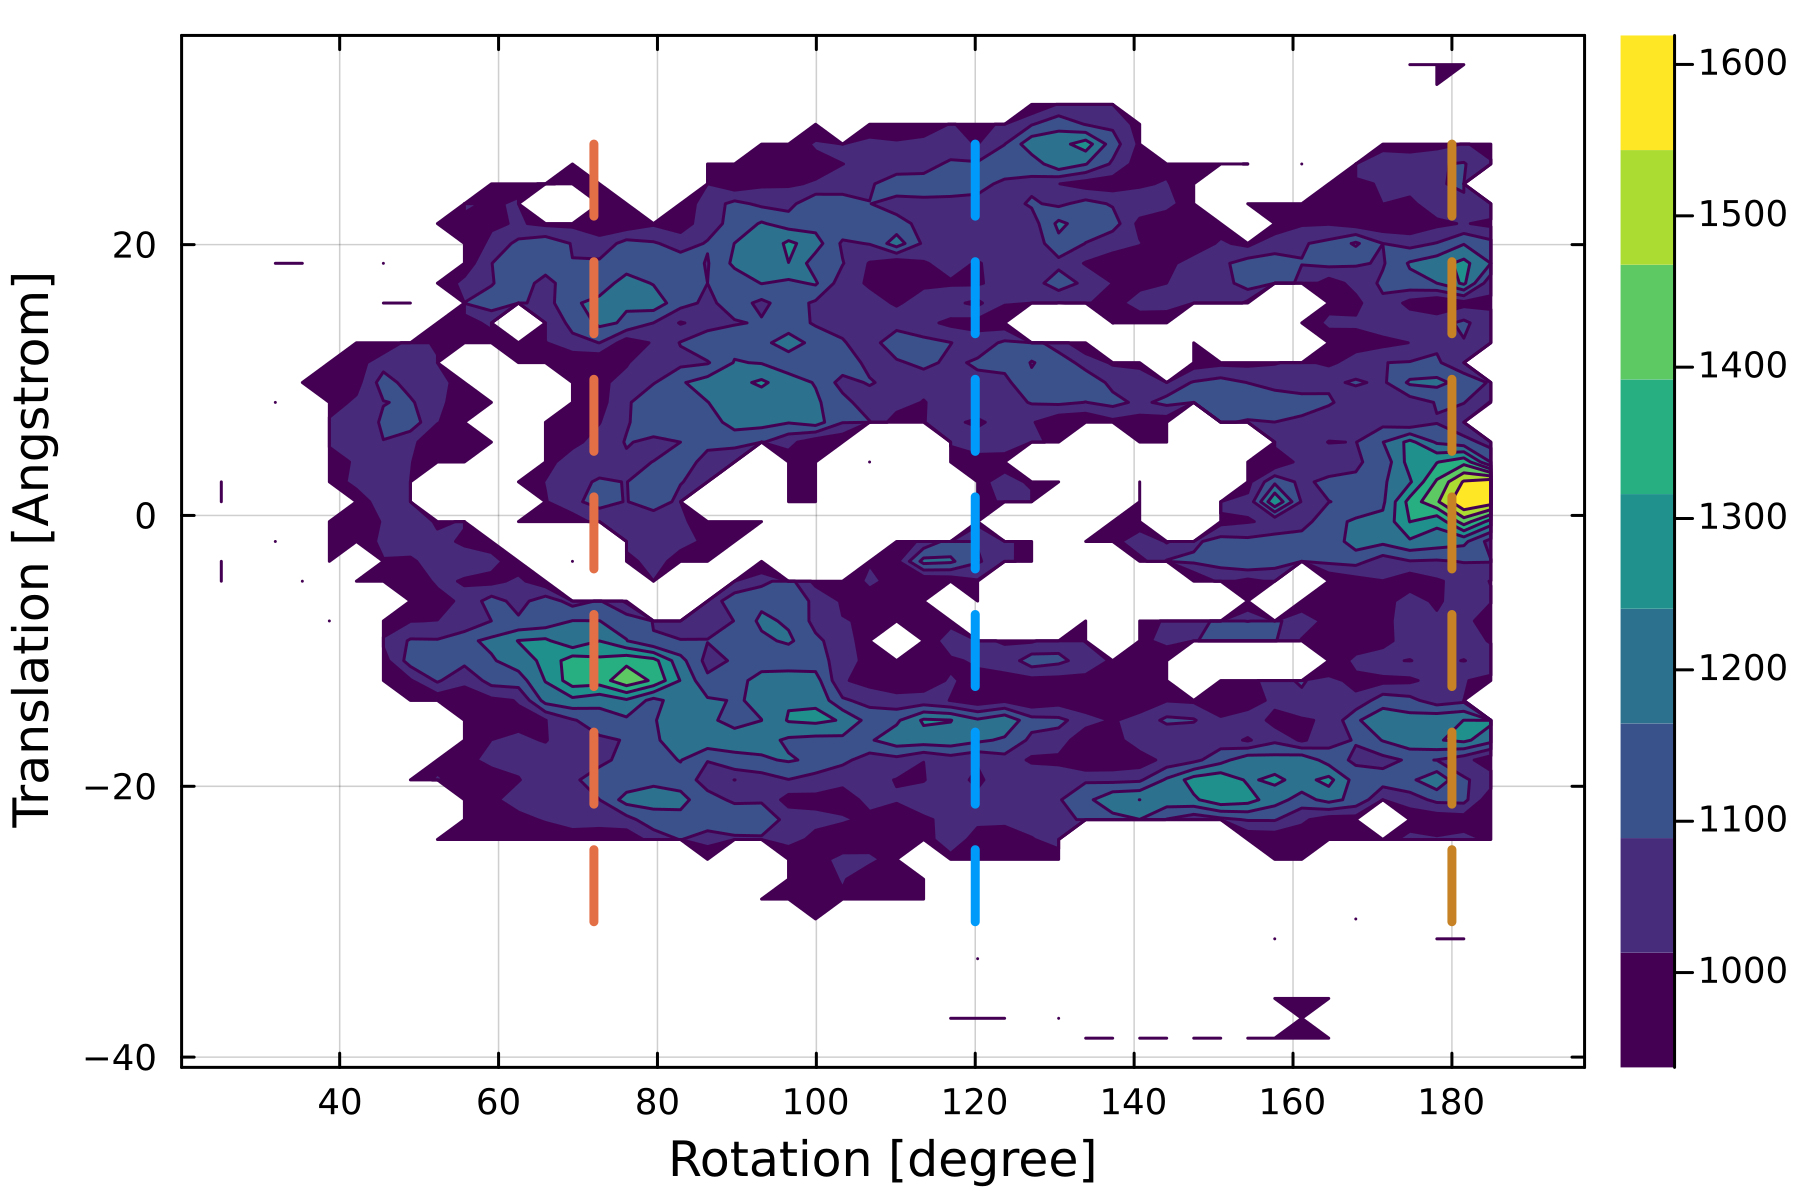

In [34]:
n = 100000
F = create_heatmap(df.phi[1:n], df.d[1:n], df.score[1:n], 50, 50)
p = plot(F.x, F.y, F.z, framestyle=:box, dpi=300, c=:viridis,  
     st=:contourf, levels=range(minimum(F.z[F.z .> -Inf]), maximum(F.z), 10))
xlabel!("Rotation [degree]")
ylabel!("Translation [Angstrom]")

s = collect(-30:30)
plot!(fill(360/5, length(s)), s, linestyle=:dash, linewidth=3.0, linecolor=2, label=nothing)
plot!(fill(360/3, length(s)), s, linestyle=:dash, linewidth=3.0, linecolor=1, label=nothing)
plot!(fill(360/2, length(s)), s, linestyle=:dash, linewidth=3.0, linecolor=24, label=nothing)

In [35]:
savefig(p, "heatmap_score.png")
savefig(p, "heatmap_score.pdf")

"/data3/yasu/capsid/docking_pairwise/1stm_zdock_iter/heatmap_score.pdf"

In [19]:
function create_heatmap_min(x, y, z, nx, ny)
    A = zeros(Float64, ny, nx)
    A .= -Inf64
    #edge_x = range(minimum(x), maximum(x), nx+1)
    edge_x = range(20, 190, nx+1)
    edge_y = range(minimum(y), maximum(y), ny+1)
    for ix in 1:nx
        for iy in 1:ny
            id_x = edge_x[ix] .<= x .< edge_x[ix+1]
            id_y = edge_y[iy] .<= y .< edge_y[iy+1]
            id = id_x .& id_y
            if !isempty(z[id])
                A[iy, ix] = minimum(z[id])
            end
        end
    end
    grid_x = edge_x[1:end-1] .+ (0.5 * (edge_x[2] - edge_x[1])) .+ (edge_x[2] - edge_x[1])
    grid_y = edge_y[1:end-1] .+ (0.5 * (edge_y[2] - edge_y[1])) .+ (edge_y[2] - edge_y[1])    
    return (z=A, x=grid_x, y=grid_y)
end

create_heatmap_min (generic function with 1 method)

In [20]:
using Combinatorics

function compute_rmsd_permute(ref, t, nmer)
    natom = Int(t.natom / nmer)
    nmer_ref = Int(ref.natom / natom)
    index_pairs = collect(permutations(1:nmer_ref, nmer))
    rmsd = Inf64
    for index in index_pairs
        id = Vector{Int}(undef, 0)
        for imer = 1:nmer
            id = [id; (natom*(index[imer]-1)+1):(natom * index[imer])]
        end
        ref2 = ref[:, id]
        t2 = superimpose(ref2, t)
        r = compute_rmsd(ref2, t2)
        if r[1] < rmsd
            rmsd = r[1]
        end
    end
    return rmsd
end

compute_rmsd_permute (generic function with 1 method)

In [21]:
t = mdload("ref.pdb")
#t = t["atomname CA"]
ref = t[1, :]
for imer = 2:60
    ref = hcat(ref, t[imer, :])
end
ref

1x8460 TrjArray{Float64, Int64}
| A                          |  …   A                          |
| 17ALA                      |  …   157SER                     |
| 2CA                        |  …   63301CA                    |
|    20.03    52.06    14.45 |  …      57.60    54.66   -12.10 |

In [22]:
function read_ascii(fname)
    lines = readlines(fname)
    natom = length(lines) - 1
    xyz = zeros(Float64, 1, natom*3)
    for i = 1:natom
        xyz[1, 3*(i-1)+1] = parse(Float64, lines[i+1][31:38])
        xyz[1, 3*(i-1)+2] = parse(Float64, lines[i+1][39:46])
        xyz[1, 3*(i-1)+3] = parse(Float64, lines[i+1][47:54])
    end
    TrjArray(xyz=xyz)
end

read_ascii (generic function with 1 method)

In [49]:
ntop = 5000
rmsd = zeros(Float64, ntop)
t = mdload("1/complex.1.pdb")
id = select_atom(t, "atomname CA")

for i in 1:ntop
    filename = df.fnames[i]
    t = read_ascii(filename)
    t_ca = t[:, id]
    rmsd[i] = compute_rmsd_permute(ref, t_ca, 2)
end

More than 50 iterations needed!More than 50 iterations needed!More than 50 iterations needed!More than 50 iterations needed!More than 50 iterations needed!More than 50 iterations needed!More than 50 iterations needed!More than 50 iterations needed!

In [54]:
ntop = 3000

3000

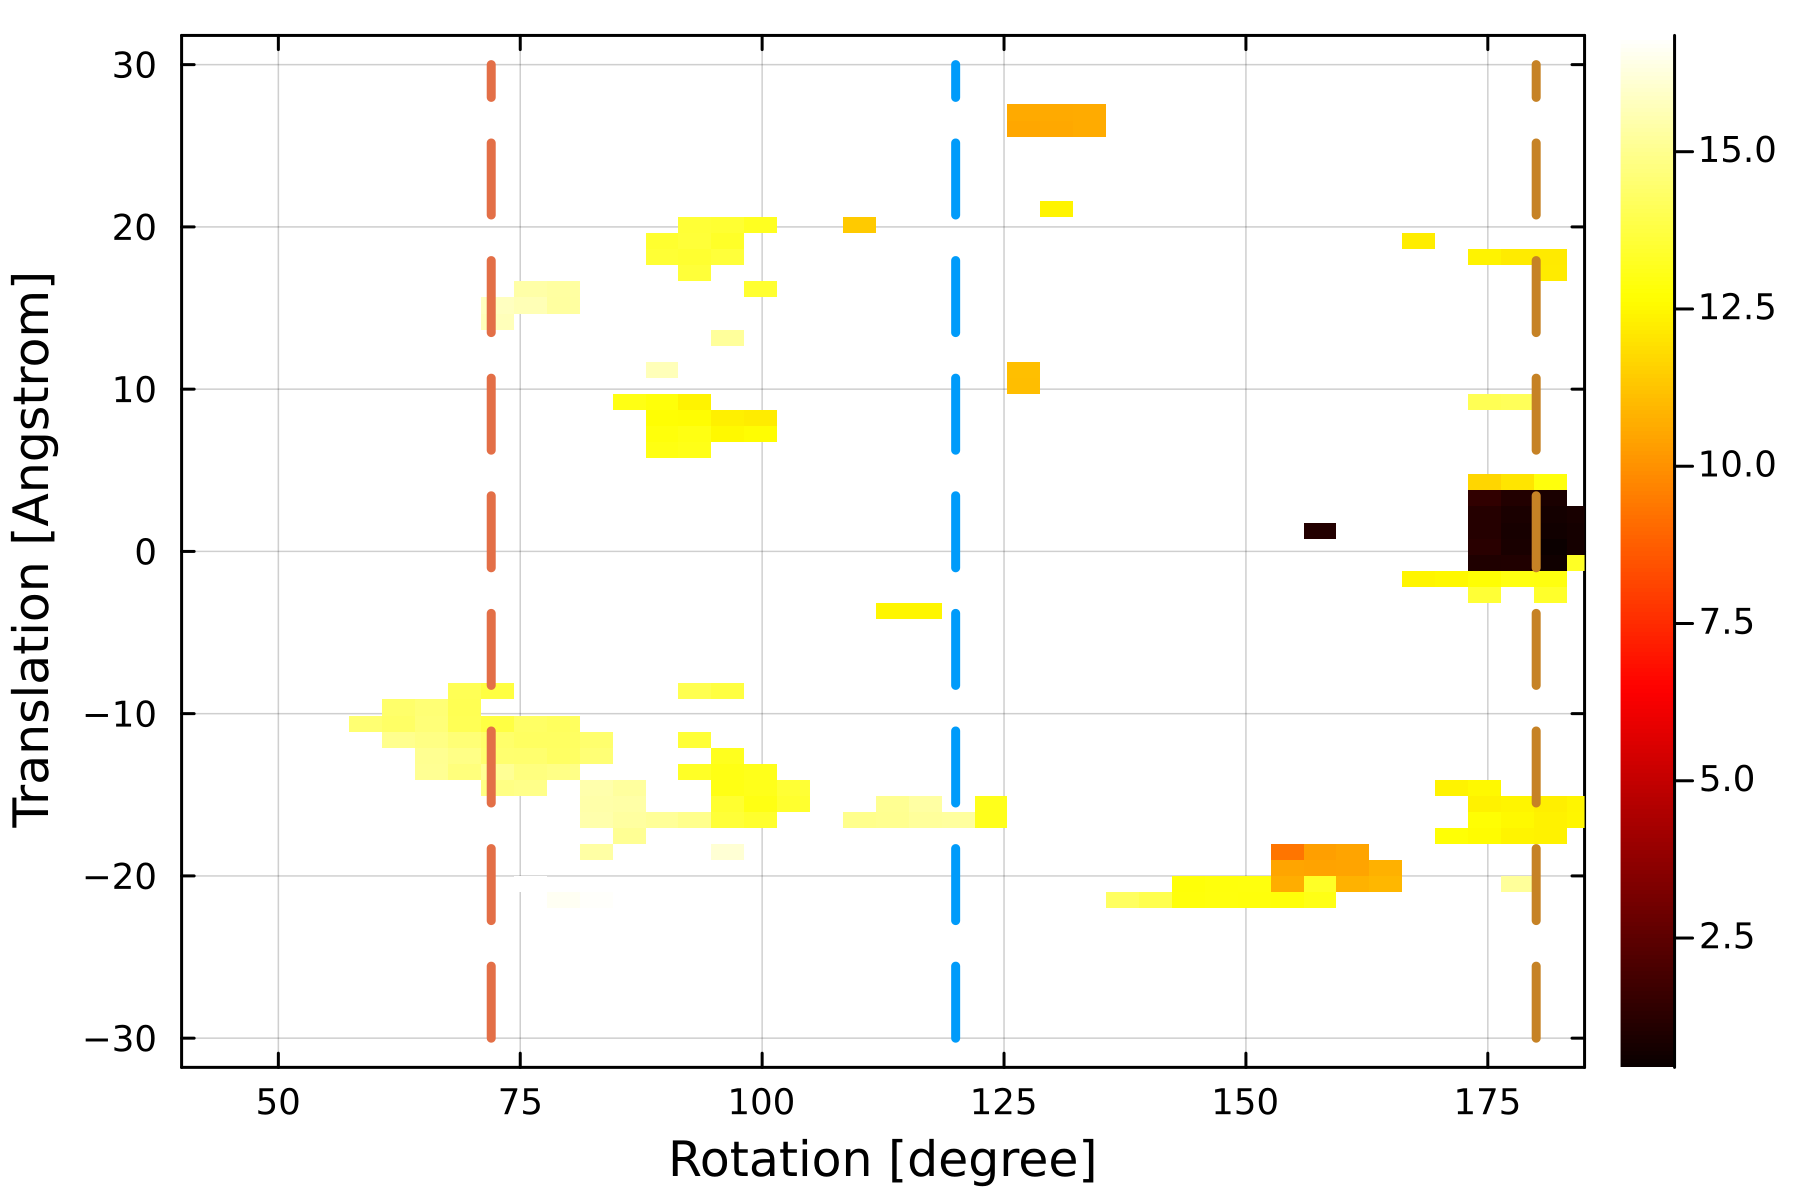

In [55]:
F = create_heatmap_min(df.phi[1:ntop], df.d[1:ntop], rmsd[1:ntop], 50, 50)
p = plot(F.x, F.y, F.z, framestyle=:box, dpi=300, c=:hot,  
     st=:heatmap, levels=range(0, maximum(F.z), 10), xlim=(40, 185))
xlabel!("Rotation [degree]")
ylabel!("Translation [Angstrom]")

s = collect(-30:30)
plot!(fill(360/5, length(s)), s, linestyle=:dash, linewidth=3.0, linecolor=2, label=nothing)
plot!(fill(360/3, length(s)), s, linestyle=:dash, linewidth=3.0, linecolor=1, label=nothing)
plot!(fill(360/2, length(s)), s, linestyle=:dash, linewidth=3.0, linecolor=24, label=nothing)

In [56]:
savefig(p, "heatmap_rmsd.png")
savefig(p, "heatmap_rmsd.pdf")

"/data3/yasu/capsid/docking_pairwise/1stm_zdock_iter/heatmap_rmsd.pdf"

In [57]:
using JLD2

save("rmsd.jld2", "rmsd", rmsd)

In [58]:
pwd()

"/data3/yasu/capsid/docking_pairwise/1stm_zdock_iter"